<a href="https://colab.research.google.com/github/Varvara225/NNetwork_4-year/blob/main/hw1_%D0%92%D0%B0%D1%81%D0%B8%D0%BB%D1%8C%D0%B5%D0%B2%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Практическое задание. Обучение полносвязной нейронной сети.

**ФИО**: Васильева Варвара Вячеславовна

### Большая просьба

Называйте файл hw1_Фамилия.ipynb

In [2]:
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

In [3]:
import os
import tqdm

## 1. Загрузка данных (2 балла)

Если вам требуется работать с каким-нибубь набором данных (dataset), то прежде всего проверьте нет ли его среди встроенных наборов данных https://pytorch.org/vision/stable/datasets.html.

В текущем домашнем задании мы будем работать с набором данных FashionMNIST. Это не совсем про тексты, но зато он численный и его можно вытянуть в вектор. Это легко и полезно, чтобы отработать разные приемы. Он присутствует в списке встроенных наборов данных, однако мы воспользуемся реализацией только для удобного и быстрого способа скачать наборы данных. Ниже предлагается реализовать собственный класс для считывания, обработки и упаковки данных.

In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

100%|██████████| 26421880/26421880 [00:02<00:00, 13154321.56it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209755.71it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3907085.91it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20801808.28it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Воспользуемся функцией загрузки данных из репозитория наборов данных.

In [5]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   t10k-labels-idx1-ubyte.gz   train-labels-idx1-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte     train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte	   train-images-idx3-ubyte.gz


In [6]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path: str, kind: str = 'train'): #-> Tuple[np.ndarray, np.ndarray]:
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Для удобства PyTorch предоставляет ряд базовых классов `Dataset, DataLoader`, от которых предлагается отнаследоваться при разработке пользовательских классов. Базовый класс `Dataset` используется для загрузки и обработки данных, класс `DataLoader` используется для управления процессом загрузки данных, позволяет в многопоточном режиме загружать данные и упаковывать их.
Эти вспомогательные классы находятся в модуле `torch.utils.data`.

При наследовании от класса `torch.utils.data.Dataset` требуется переопределить метод `__len__`, который возвращает количество примеров в наборе данных, а также метод `__getitem__`, который позволяет получить доступ к примеру из набора данных по индексу.

Реализуем класс для FasionMnist.

Элементами датасета должны являться пары '(np.array, int)', массив имеет размерность `(28, 28)`, тип элемента `np.float32`.

In [7]:

class my_FashionMnist(Dataset):
    def __init__(self, path, train=True, image_transform=None,
                 label_transform=None):

        ### YOUR CODE HERE
        ### LOAD IMAGES AND LABELS WITH FUNCTION
        if train:
          self.images, self.labels = load_mnist(path, 'train')
        else:
          self.images, self.labels = load_mnist(path, 't10k')


        ### ALSO PROVIDE TRANSFORMS TO APPLY
        self.image_transform = image_transform
        self.label_transform = label_transform



    def __len__(self,):

        ### YOUR CODE
        # RETURN LENGTH OF DATASET
        return len(self.images)


    def __getitem__(self, idx):


        ### YOUR CODE HERE
        ### APPLY TRANSFORMS AND RETURN ELEMENTS
        if self.image_transform:
          image = self.image_transform(np.reshape(self.images[idx], (28, 28)))
        else:
          image = np.reshape(self.images[idx], (28, 28)).astype(np.float32)

        if self.label_transform:
          label = self.label_transform(self.labels[idx])
        else:
          label = int(self.labels[idx])

        return (image, label)

In [8]:
test_dataset = my_FashionMnist("data/FashionMNIST/raw", train=False)
train_dataset = my_FashionMnist("data/FashionMNIST/raw")

Визуализируйте случайные элементы набора данных.

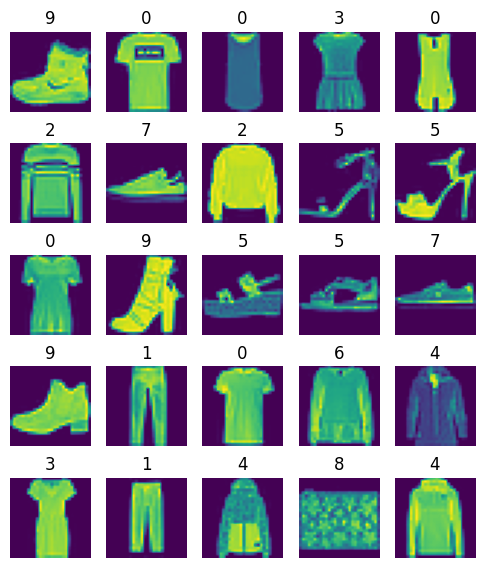

In [9]:
### YOUR CODE HERE

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_dataset[i][0])
    plt.title(train_dataset[i][1])
    plt.axis('off')

В конструктор `Dataset` можно передать объект `torchvision.transforms`, который позволяет преобразовать исходные данные. Преобразование `torchvision.transforms.ToTensor` позволяет преобразоать данные из типа `PIL Image` и `numpy.float32` в тип `torch.float32`

Реализуйте собственную поддержку преобразований в `FashionMnist`. Проверьте, что приведение типов работает корректно.

In [11]:
class my_ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        ### YOUR CODE HERE
        return torch.tensor(sample, dtype=torch.double)

# SHOULD BE CALLABLE ToTensor(x)

In [12]:
transform = my_ToTensor()

### YOUR CODE HERE
# init dataset with your transform and check datatype
test_dataset = my_FashionMnist("data/FashionMNIST/raw", train=False, image_transform=transform)
train_dataset = my_FashionMnist("data/FashionMNIST/raw", image_transform=transform)

test_dataset[0][0].dtype, test_dataset[0][0].size()

(torch.float64, torch.Size([28, 28]))

Элементы набора данных могут быть объединены в пакеты (batch) явно и неявно. Если данные могут быть сконкатенированы или обЪединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [13]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True)
batch = next(iter(test_dataloader))

In [14]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


Однако, если наша структура данных не позволяет нам использовать объединение по умолчанию, то можно написать собственную функцию, которая будет пакетировать данные.

Реализуйте функцию, преобразующую последовательность элементов массива в пакет (batch).

In [15]:
### YOUR CODE HERE
### WRITE A COLLATE FUNCTION and use it with dataloaders

def M_my_collate_fn(batch):

    inputs, targets = zip(*batch)


    inputs = torch.stack(inputs).double()
    targets = torch.tensor(targets).long()

    return inputs, targets

Убедитесть, что все работает корректно.

In [16]:
test_dataloader = DataLoader(test_dataset, batch_size=15,
                             num_workers=2, shuffle=True,
                             collate_fn=M_my_collate_fn)
train_dataloader = DataLoader(train_dataset, batch_size=15,
                             num_workers=2, shuffle=True,
                             collate_fn=M_my_collate_fn)
batch = next(iter(test_dataloader))

In [17]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")
print(f"The shape of the batch[1] is {batch[1].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])
The shape of the batch[1] is torch.Size([15])


## 2. Реализация модулей нейронной сети (3 балла)

В этом разделе мы полностью реализуем модули для полносвязанной сети.

Для начала нам понадобится реализовать прямой и обратный проход через слои.

Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиент.

In [18]:
class IdentityFunction(Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        return input

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        return grad_output

Разработанную функцию обернем классом `IdentityLayer`, все слои в `PyTorch` должны быть наследниками базового класса `nn.Module()`


In [19]:
class IdentityLayer(nn.Module):
    def __init__(self):
        # An identity layer does nothing
        super().__init__()
        self.identity = IdentityFunction.apply

    def forward(self, inp):
        # An identity layer just returns whatever it gets as input.
        return self.identity(inp)


### 2.1 Функция активации ReLU
Для начала реализуем функцию активации, слой нелинейности `ReLU(x) = max(x, 0)`. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения `ReLU` к входному массиву, метод `backward` - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [20]:
class my_ReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):

        ### YOUR CODE HERE
        ### CALCULATE RELU FUNCTION WITH TORCH AND SAVE SOMETHING FOR BACKWARD VIA CTX
        ctx.save_for_backward(input)
        output = torch.relu(input)
        return output


    @staticmethod
    def backward(ctx, grad_output):

        ### YOUR CODE HERE
        ### GET SOMETHING FROM FORWARD AND CALCULATE GRADIENT
        # CHECK LECTIONS OR GOOGLE
        input, = ctx.saved_tensors
        out = torch.where(input > 0, torch.tensor(1.0), torch.tensor(0.0))

        return grad_output * out


In [21]:
class ReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = my_ReLUFunction.apply

    def forward(self, input):
        return self.relu(input)

Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [22]:
torch.manual_seed(0)

x = torch.rand((7,15), requires_grad = True, dtype=torch.double)
relu = ReLU()

assert gradcheck(relu, x)

In [23]:
torch_relu = torch.relu
our_relu = ReLU()

assert torch.norm(torch_relu(x.float()) - our_relu(x)) < 1e-5

### 2.2 Линейный слой (linear, fully-connected)
Далее реализуем полносвязный слой без нелинейности. У слоя два набора параметра: матрица весов (weights) и вектор смещения (bias).

In [24]:
class my_LinearFunction(Function):
    @staticmethod
    def forward(ctx, inp, weight, bias):

        ### YOUR CODE HERE
        ### CALCULATE OUTPUT
        ### AND SAVE SOMETHING FOR BACKWARD

        ctx.save_for_backward(inp, weight)
        output = inp @ weight.T + bias
        return output

    @staticmethod
    def backward(ctx, grad_output):

        # GET SOMETHING FROM BACKWARD
        inp, weight = ctx.saved_tensors

        # CHECK HOW BACKWARD PERFORMED
        grad_bias = grad_output.sum(0)
        grad_weight = grad_output.T @ inp
        grad_input =  grad_output @ weight

        return grad_input, grad_weight, grad_bias

In [27]:
class my_Linear(nn.Module):
    def __init__(self, input_units, output_units):
        super().__init__()

        ### YOUR CODE HERE
        ### initialize weights and bias with small random numbers or xavier
        ### do not forget to make them torch.nn.Parameter
        self.weight = nn.Parameter(torch.empty(output_units, input_units, dtype=torch.double))
        nn.init.xavier_normal_(self.weight)

        self.bias = nn.Parameter(torch.randn(output_units, dtype=torch.double) * 0.01)
        self.linear = my_LinearFunction.apply

    def forward(self,inp):

        return self.linear(inp, self.weight, self.bias)


Проверим градиент, а также сравним с работой нашего модуля с имплементированным в `PyTorch`.

Проверка градиента:

In [28]:
torch.manual_seed(0)

x = torch.rand((6,12), requires_grad = True, dtype=torch.double)
linear = my_Linear(12, 14)

assert gradcheck(linear, x)

Сравнение с `PyTorch`.

In [29]:
output_units = 32
input_units = 15

x = torch.rand((16,15), requires_grad = True, dtype=torch.double)


weight = torch.rand(size=(output_units, input_units), dtype=torch.double)
bias = torch.rand(size=(output_units,), dtype=torch.double)

torch_linear = torch.nn.Linear(input_units, output_units, dtype=torch.double)
our_linear = my_Linear(input_units, output_units)


state_dict = OrderedDict([("weight", weight), ("bias", bias)])
torch_linear.load_state_dict(state_dict)
our_linear.load_state_dict(state_dict)


torch_forward = torch_linear.forward(x)
our_forward = our_linear(x)
assert torch.allclose(torch_forward, our_forward)

## 3. Сборка и обучение нейронной сети (5 баллов)

Реализуйте произвольную нейросеть, состоящую из ваших блоков. Она должна состоять из нескольких полносвязанных слоев.

In [30]:
class Network(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10):
        super().__init__()


        ### YOUR CODE HERE
        ### STACK LAYERS WITH DEFINED PARAMETERS
        ### USE nn.Dropout, your linear, your relu and whatever you like
        ### LAST LAYER SHOULD BE nn.LogSoftmax
        layers = []
        prev_dim = input_size
        layers.append(nn.Flatten(end_dim=-1))
        for l in range(num_layers - 1):
            layers.append(my_Linear(prev_dim, hidden_layers_size))
            layers.append(ReLU())
            prev_dim = hidden_layers_size

        layers.append(my_Linear(prev_dim, num_classes))
        layers.append(torch.nn.LogSoftmax(dim=1))

        self.net = torch.nn.Sequential(*layers)

    def forward(self, inp):

        ### YOUR CODE HERE
        ### APPLY YOUR NET TO THE INPUT
        return self.net(inp)


In [45]:
my_model = Network()
my_model

Network(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): my_Linear()
    (2): ReLU()
    (3): my_Linear()
    (4): ReLU()
    (5): my_Linear()
    (6): ReLU()
    (7): my_Linear()
    (8): ReLU()
    (9): my_Linear()
    (10): LogSoftmax(dim=1)
  )
)

Ниже вам предстоит написать цикл обучения. Сначала это бывает больно, но потом уже на автомате делается, в начале так всегда


In [50]:
class EmptyContext:
    def __enter__(self):
        pass

    def __exit__(self, *args):
        pass

In [32]:
# accuracy metric for our classififcation
def accuracy(model_labels, labels):
  return torch.mean((model_labels == labels).float())

Теперь обучим нашу нейронную сеть.

In [33]:
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model = model.to(device)
    model.train(True)

    losses = []
    for batch in dataloader:

        xs, ys_true = batch
        xs = xs.to(device)
        ys_true = ys_true.to(device)

        ys_pred = model(xs)
        loss = loss_fn(ys_pred, ys_true)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)

In [34]:
def val_epoch(model, dataloader, loss_fn, device):
    model = model.to(device)
    model.eval()

    losses = []
    preds = []
    val_accuracy = []
    for batch in dataloader:
        xs, ys_true = batch
        xs = xs.to(device)
        ys_true = ys_true.to(device)
        with torch.no_grad():
            ys_pred = model(xs)

        loss = loss_fn(ys_pred, ys_true)
        losses.append(loss.item())

        preds.append(ys_pred.numpy())

        val_accuracy.append(accuracy(torch.argmax(ys_pred, dim=-1), ys_true))

    preds = np.concatenate(preds, axis=0)
    return np.mean(losses), preds, np.mean(val_accuracy)

Дальше:
- Проведите эксперименты с числом слоев.
- Постройте графики зависимости качества модели на тренировочной и тестовой выборках от числа слоев. Для получения статистически значимых результатов повторите эксперименты несколько раз.
- Сделайте выводы.

In [41]:
# SET NUMBER OF EPOCHS
num_lay = [2, 5, 10, 15]
device = torch.device("cpu")
loss_fn = nn.NLLLoss()
num_epochs = 5

In [42]:
final_acc = []

for n in num_lay:

  model = Network(num_layers=n)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

  losses = []
  val_losses = []
  val_preds = []
  acc_nlayers = []

  for epoch in tqdm.trange(num_epochs):
      loss = train_epoch(model, train_dataloader, optimizer, loss_fn, device)
      losses.append(loss)

      val_loss, preds, acc = val_epoch(model, test_dataloader, loss_fn, device)
      val_losses.append(val_loss)
      val_preds.append(preds)
      acc_nlayers.append(acc)
      print(f"Epoch - {epoch} : loss {np.mean(losses)}, accuracy {acc}")

  final_acc.append(np.mean(acc_nlayers))

# TRAIN AND VALIDATE
# LOG METRICS FOR TRAIN AND VAL LIKE BELOW. (YOU MAY USE YOUR OWN WAY)

 20%|██        | 1/5 [00:13<00:52, 13.14s/it]

Epoch - 0 : loss 2.4498138846227158, accuracy 0.3370314836502075


 40%|████      | 2/5 [00:25<00:38, 12.89s/it]

Epoch - 1 : loss 2.083788471449206, accuracy 0.37381312251091003


 60%|██████    | 3/5 [00:38<00:25, 12.87s/it]

Epoch - 2 : loss 1.924686109616885, accuracy 0.3616691827774048


 80%|████████  | 4/5 [00:51<00:12, 12.94s/it]

Epoch - 3 : loss 1.834463178600319, accuracy 0.41984012722969055


100%|██████████| 5/5 [01:04<00:00, 12.89s/it]


Epoch - 4 : loss 1.7737202702832096, accuracy 0.3614692687988281


 20%|██        | 1/5 [00:16<01:05, 16.49s/it]

Epoch - 0 : loss 1.0709350383655842, accuracy 0.6863068342208862


 40%|████      | 2/5 [00:32<00:48, 16.05s/it]

Epoch - 1 : loss 0.872350517426153, accuracy 0.7466766238212585


 60%|██████    | 3/5 [00:47<00:31, 15.85s/it]

Epoch - 2 : loss 0.7798519315786275, accuracy 0.7547226548194885


 80%|████████  | 4/5 [01:03<00:15, 15.63s/it]

Epoch - 3 : loss 0.7212965980503834, accuracy 0.8102948665618896


100%|██████████| 5/5 [01:18<00:00, 15.68s/it]


Epoch - 4 : loss 0.677061491792292, accuracy 0.7991004586219788


 20%|██        | 1/5 [00:19<01:18, 19.69s/it]

Epoch - 0 : loss 0.8236636848650257, accuracy 0.7812594175338745


 40%|████      | 2/5 [00:39<01:00, 20.05s/it]

Epoch - 1 : loss 0.6936660328755421, accuracy 0.8052974939346313


 60%|██████    | 3/5 [00:59<00:39, 19.76s/it]

Epoch - 2 : loss 0.6305675328526349, accuracy 0.8149924874305725


 80%|████████  | 4/5 [01:19<00:20, 20.04s/it]

Epoch - 3 : loss 0.5898572853830126, accuracy 0.8262869119644165


100%|██████████| 5/5 [01:39<00:00, 19.92s/it]


Epoch - 4 : loss 0.5613576567990443, accuracy 0.8251874446868896


 20%|██        | 1/5 [00:24<01:37, 24.40s/it]

Epoch - 0 : loss 0.942666026081941, accuracy 0.7263868451118469


 40%|████      | 2/5 [00:48<01:12, 24.09s/it]

Epoch - 1 : loss 0.7711511452919517, accuracy 0.778710663318634


 60%|██████    | 3/5 [01:11<00:47, 23.77s/it]

Epoch - 2 : loss 0.689508909263647, accuracy 0.7901549935340881


 80%|████████  | 4/5 [01:35<00:23, 23.93s/it]

Epoch - 3 : loss 0.6391853598339187, accuracy 0.8162419199943542


100%|██████████| 5/5 [01:59<00:00, 23.98s/it]

Epoch - 4 : loss 0.6032448133294499, accuracy 0.8300350308418274


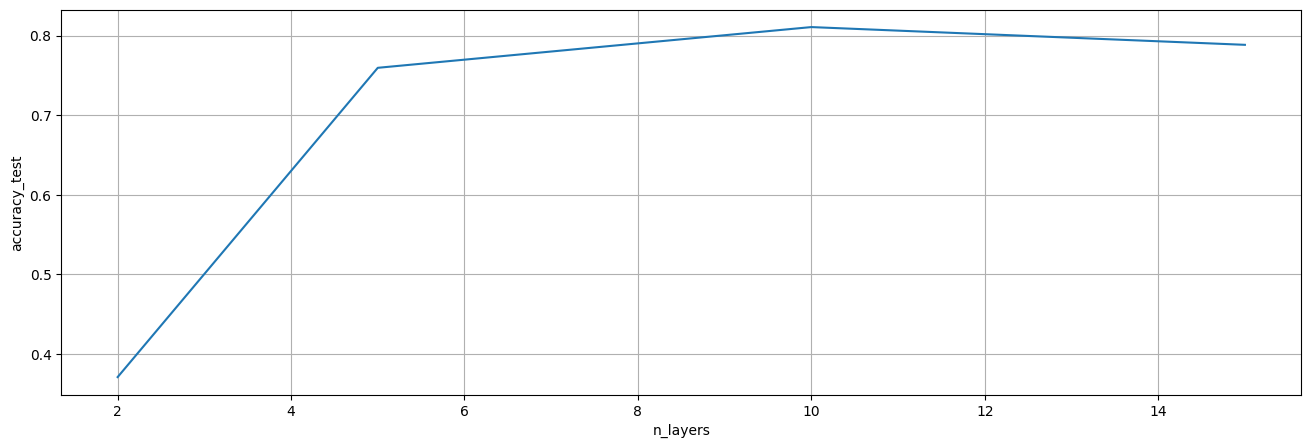

In [44]:
plt.figure(figsize=(16, 5))

# plt.subplot(1, 2, 1)
plt.plot(num_lay, final_acc)
plt.grid(True)
plt.xlabel("n_layers")
plt.ylabel("accuracy_test")

plt.show()

## 4. Бонусная часть.

### 4.1 Реализация метода оптимизации (1 балл).
Реализуйте сами метод оптимизации  для рассмотренной выше архитектуры. Вы можете выбрать произвольный метод от градиентного спуска до современных вариантов. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с Adam.

**Дополнительные баллы** вы получите, если метод будет уникален среди сдавших задание.

In [ ]:
class SotaOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super(SotaOptimizer, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SotaOptimizer, self).__setstate__(state)

    @torch.no_grad()
    def step(self,):

        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is not None:
                    p.data.add_(-lr*p.grad)

### 4.2 Реализация современной функции активации (1 балл).
Реализуйте одну из современных функций активации. Например, `Hardswish` или `GELU`. Сравните сеть с вашей активацией и с `ReLU`.

**Дополнительные баллы** вы получите, если функция будет уникальна среди сдавших задание.